In [1]:
import cv2 as CV
import numpy as NP
import matplotlib.pyplot as PLT
import imutils.paths as IP
import skimage.filters as SF

In [2]:
IMAGES = list(IP.list_images('DataSeq3'))

In [3]:
def PYRAMID(I1,I2):
    

    row = I1.shape[0]
    col = I2.shape[1]

    NEW_I1 = NP.zeros((row,int(col/2)))
    NEW_I2 = NP.zeros((row,int(col/2)))

    TEMP = NP.zeros((1,5))

    G_mask = NP.array([1/20,1/4,2/5,1/4,1/20])

    Y1 = NP.zeros((row,col+3))
    Y2 = NP.zeros((row,col+3))

    Y1[0:row,2:(col+2)] = I1
    Y2[0:row,2:(col+2)] = I2

    for ROW in range(0,Y1.shape[0]):
        for COL in range(2,Y2.shape[1]-2,2):
            TEMP1 = NP.sum(Y1[ROW,COL-2:COL+3] * G_mask)
            TEMP2 = NP.sum(Y2[ROW,COL-2:COL+3] * G_mask)
            NEW_I1[ROW,int(COL/2)-1]= TEMP1
            NEW_I2[ROW,int(COL/2)-1]= TEMP2

    TEMP_I1 = NP.zeros((NEW_I1.shape[0]+3,NEW_I1.shape[1]))
    TEMP_I2 = NP.zeros((NEW_I1.shape[0]+3,NEW_I1.shape[1]))

    TEMP_I1[2:TEMP_I1.shape[0]-1,0:TEMP_I1.shape[1]] = NEW_I1
    TEMP_I2[2:TEMP_I1.shape[0]-1,0:TEMP_I1.shape[1]] = NEW_I2

    ORIGINAL_I1 = NP.zeros((int(I1.shape[0]/2),int(I1.shape[1]/2)))
    ORIGINAL_I2 = NP.zeros((int(I1.shape[0]/2),int(I1.shape[1]/2)))

    for COL in range(0,TEMP_I1.shape[1]):
        for ROW in range(2,TEMP_I1.shape[0]-2,2):
            TEMP1 = NP.sum(TEMP_I1[ROW-2:ROW+3,COL] *G_mask)
            TEMP2 = NP.sum(TEMP_I2[ROW-2:ROW+3,COL] *G_mask)
            ORIGINAL_I1[int(ROW/2)-1,COL] = TEMP1
            ORIGINAL_I2[int(ROW/2)-1,COL] = TEMP2
    
    return ORIGINAL_I1,ORIGINAL_I2
        

    
    

In [4]:
#....NORAML LUKAS KANNADE FUNCTION:
def LUKAS_KANNADE(I1,I2):
    #I1 = CV.cvtColor(IM1,CV.COLOR_BGR2GRAY)
    #I2 = CV.cvtColor(IM2,CV.COLOR_BGR2GRAY)
    ROW_1 = I1.shape[0]
    COL_1 = I1.shape[1]
    ROW_2 = I2.shape[0]
    COL_2 = I2.shape[1]
    F_XD = NP.abs(SF.sobel_v(I1))
    F_YD = NP.abs(SF.sobel_h(I1))
    U = NP.zeros((ROW_1,COL_1))
    V = NP.zeros((ROW_1,COL_1))
    
    for row in range(1,ROW_1-1):
        for col in range(1,COL_1-1):
            r = row-1
            c = col-1
            WINDOW_1 = I1[r:r+3,c:c+3]
            WINDOW_2 = I2[r:r+3,c:c+3]
            F_T = WINDOW_2 - WINDOW_1
            F_X = F_XD[r:r+3,c:c+3]
            F_Y = F_YD[r:r+3,c:c+3]
            A = NP.zeros((9,2))
            A[0:9,0:1] = F_X.reshape(9,1)
            A[0:9,1:2] = F_Y.reshape(9,1)
            T = F_T.reshape(9,1)
            if NP.linalg.det(NP.dot(NP.transpose(A),A)) != 0:
                S = NP.dot(NP.dot(NP.linalg.inv(NP.dot(NP.transpose(A),A)),NP.transpose(A)),T)
                
                U[row,col] = S[0][0]
                V[row,col] = S[1][0]
    temp_U = NP.sqrt(NP.sum(NP.square(U)))
    temp_V = NP.sqrt(NP.sum(NP.square(V)))
    for i in range(0,U.shape[0]):
        for j in range(0,U.shape[1]):
            U[i,j] =  (U[i,j]/temp_U)
            V[i,j] = (V[i,j]/temp_V)
            
    return U,V
            
            

In [5]:
def INTERPOLATION(U,V):
    NEW_U = NP.zeros((U.shape[0]*2,U.shape[1]*2))
    NEW_V = NP.zeros((V.shape[0]*2,V.shape[1]*2))
    P_U = NP.zeros((3,3))
    P_V = NP.zeros((3,3))
    for row in range(0,NEW_U.shape[0],2):
        for col in range(0,NEW_U.shape[1],2):
            NEW_U[row,col] = U[int(row/2),int(col/2)]
            NEW_V[row,col] = V[int(row/2),int(col/2)]
    
    for row in range(0,NEW_U.shape[0]-3,2):
        for col in range(0,NEW_U.shape[1]-3,2):
            P_U = NEW_U[row:row+3,col:col+3]
            P_V = NEW_V[row:row+3,col:col+3]
            
            temp_u =   P_U[0,0]*4 + P_U[0,2] +P_U[2,0]*2 + P_U[2,2]
            temp_v =   P_V[0,0]*4 + P_V[0,2] +P_V[2,0]*2 + P_V[2,2]
            
            
            NEW_U[row,col+1] = temp_u
            NEW_U[row+1,col] = temp_u
            NEW_U[row+1,col+1] = temp_u
            NEW_U[row+1,col+2] = temp_u
            NEW_U[row+2,col+1] = temp_u
            
            NEW_V[row,col+1] = temp_v
            NEW_V[row+1,col] = temp_v
            NEW_V[row+1,col+1] = temp_v
            NEW_V[row+1,col+2] = temp_v
            NEW_V[row+2,col+1] = temp_v
            
    return NEW_U,NEW_V
    
    
    
    

In [6]:
#....NORAML LUKAS KANNADE FUNCTION:
def LUKAS_2(I1,I2,MY_U,MY_V):
    #I1 = CV.cvtColor(IM1,V.COLOR_BGR2GRAY)
    #I2 = CV.cvtColor(IM2,CV.COLOR_BGR2GRAY)
    ROW_1 = I1.shape[0]
    COL_1 = I1.shape[1]
    ROW_2 = I2.shape[0]
    COL_2 = I2.shape[1]
    F_XD = NP.abs(SF.sobel_v(I1))
    F_YD = NP.abs(SF.sobel_h(I1))
    U = NP.zeros((ROW_1,COL_1))
    V = NP.zeros((ROW_1,COL_1))
    
    for row in range(1,ROW_1-1):
        for col in range(1,COL_1-1):
            #WINDOW_1 = NP.zeros((3,3))
           # WINDOW_2 = NP.zeros((3,3))
            r = row-1
            c = col-1
            WINDOW_1 = I1[r:r+3,c:c+3]
            
            NEW_COL_LOC = abs(int(NP.ceil(MY_U[row,col] + col)))
            NEW_ROW_LOC = abs(int(NP.ceil(MY_V[row,col] + row)))
            if NEW_COL_LOC<=COL_1-3 and NEW_ROW_LOC<= ROW_1-3 and NEW_COL_LOC>0 and NEW_ROW_LOC>0:
                new_r = NEW_ROW_LOC-1
                new_c = NEW_COL_LOC-1
                #print(NEW_COL_LOC)
            
                WINDOW_2 = I2[new_r:new_r+3,new_c:new_c+3]
            #print(WINDOW_2)
            #print(WINDOW_1)
                F_T = WINDOW_2 - WINDOW_1
                F_X = F_XD[r:r+3,c:c+3]
                F_Y = F_YD[r:r+3,c:c+3]
                A = NP.zeros((9,2))
                A[0:9,0:1] = F_X.reshape(9,1)
                A[0:9,1:2] = F_Y.reshape(9,1)
                T = F_T.reshape(9,1)
                if NP.linalg.det(NP.dot(NP.transpose(A),A)) != 0:
                    S = NP.dot(NP.dot(NP.linalg.inv(NP.dot(NP.transpose(A),A)),NP.transpose(A)),T)
                
                    U[row,col] = S[0][0]
                    V[row,col] = S[1][0]
        temp_U = NP.sqrt(NP.sum(NP.square(U)))
        temp_V = NP.sqrt(NP.sum(NP.square(V)))
        for i in range(0,U.shape[0]):
            for j in range(0,U.shape[1]):
                U[i,j] =  (U[i,j]/temp_U)
                V[i,j] = (V[i,j]/temp_V)
            
    return U,V
            
            

(120, 160)
(120, 160)


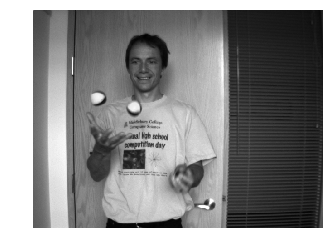

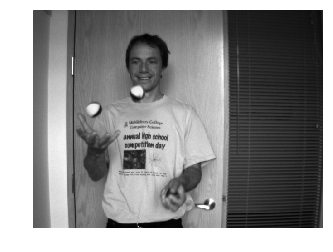

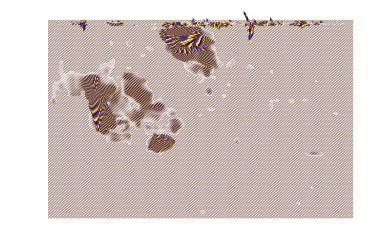

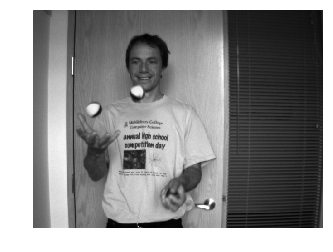

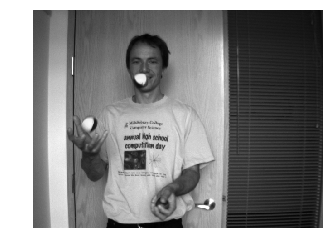

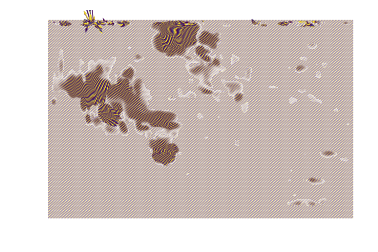

In [19]:

for i in range(0,2):
    X1 =CV.imread(IMAGES[i])
    X2 =CV.imread(IMAGES[i+1])
    I1 = CV.cvtColor(X1,CV.COLOR_BGR2GRAY)
    I2 = CV.cvtColor(X2,CV.COLOR_BGR2GRAY)

    RESIZE_X1_1,RESIZE_X2_1 = PYRAMID(I1,I2)
    RESIZE_X1_2,RESIZE_X2_2 = PYRAMID(RESIZE_X1_1,RESIZE_X2_1)
    RESIZE_X1_3,RESIZE_X2_3 = PYRAMID(RESIZE_X1_2,RESIZE_X2_2)
    U,V = LUKAS_KANNADE(RESIZE_X1_3,RESIZE_X2_3)
    U = 2*U
    V = 2*V
    U1 = CV.resize(U,(2*U.shape[1],2*U.shape[0]),CV.INTER_LINEAR )
    V1 = CV.resize(V,(2*U.shape[1],2*U.shape[0]),CV.INTER_LINEAR )
    #U1,V1 = INTERPOLATION(U,V)
    U,V = LUKAS_2(RESIZE_X1_2,RESIZE_X2_2,U1,V1)
    U = U +U1
    V = V+ V1
    U = 2*U
    V = 2*V
    print(U.shape)
    U1 = CV.resize(U,(2*U.shape[1],2*U.shape[0]),CV.INTER_LINEAR )
    V1 = CV.resize(V,(2*U.shape[1],2*U.shape[0]),CV.INTER_LINEAR )
   # U1,V1 = INTERPOLATION(U,V)
    U,V = LUKAS_2(RESIZE_X1_1,RESIZE_X2_1,U1,V1)
    U = U+U1
    V = V+V1
   # U = 2*U
    #V = 2*V
    #U1,V1 = INTERPOLATION(U,V)
    
    #U,V = LUKAS_2(I1,I2,U1,V1)
    #U = U+U1
    #V = V+V1
    X = NP.linspace(0,U.shape[1],U.shape[1])
    Y = NP.linspace(0,U.shape[0],U.shape[0])
    if i == 0:
        
        PLT.figure(1)
   # PLT.subplot(131)
        PLT.imshow(I1,'gray')
        PLT.axis('off')
    #PLT.subplot(132)
        PLT.figure(2)
        PLT.imshow(I2,'gray')
        PLT.axis('off')
        PLT.figure(3)
    #PLT.subplot(133)
        PLT.quiver(X,Y,U,V,(25,160,0))
        PLT.axis('off')
    elif i ==1:
        PLT.figure(4)
   # PLT.subplot(131)
        PLT.imshow(I1,'gray')
        PLT.axis('off')
    #PLT.subplot(132)
        PLT.figure(5)
        PLT.imshow(I2,'gray')
        PLT.axis('off')
        PLT.figure(6)
    #PLT.subplot(133)
        PLT.quiver(X,Y,U,V,(25,160,0))
        PLT.axis('off')
        

In [9]:
X1 =CV.imread(IMAGES[0])
#X2 =CV.imread(IMAGES[i+1])
I1 = CV.cvtColor(X1,CV.COLOR_BGR2GRAY)
#I2 = CV.cvtColor(X2,CV.COLOR_BGR2GRAY)

In [12]:
I1.shape[1]

640

In [14]:
A = CV.resize(I1,(320,240),CV.INTER_LINEAR)

In [15]:
A.shape

(240, 320)